##***DeepFake Detection Using Deep Learning***




## **Setup and Library Imports**

In [61]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [62]:
!pip3 install face_recognition

In [63]:
import os
import glob
import json
import copy
import random
import time
import sys
import torch
import cv2
from torch import nn
import seaborn as sn
import pandas as pd
import numpy as np
import torchvision
import face_recognition
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision import models
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

## **Helper Functions**

In [64]:
#Function to plot the image
def im_plot(tensor):
    image = tensor.cpu().numpy().transpose(1,2,0)
    b,g,r = cv2.split(image)
    image = cv2.merge((r,g,b))
    image = image*[0.22803, 0.22145, 0.216989] +  [0.43216, 0.394666, 0.37645]
    image = image*255.0
    plt.imshow(image.astype(int))
    plt.show()

In [65]:
#Function to calcuate accuracy
def calculate_accuracy(outputs, targets):
    batch_size = targets.size(0)

    _, pred = outputs.topk(1, 1, True)
    pred = pred.t()
    correct = pred.eq(targets.view(1, -1))
    n_correct_elems = correct.float().sum().item()
    return 100* n_correct_elems / batch_size

In [66]:
# Function to compute and store the average and current value"""
class AverageMeter(object):
    def __init__(self):
        self.reset()
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [67]:
#Function to print confusion matrix
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    print('\n')
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.ylabel('Actual label', size = 20)
    plt.xlabel('Predicted label', size = 20)
    plt.xticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.yticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.ylim([2, 0])
    plt.show()
    calculated_acc = (cm[0][0]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+ cm[1][1])
    print("Calculated Accuracy",calculated_acc*100)

In [68]:
#Function for plotting loss and accuracy
def plot_loss(train_loss_avg,test_loss_avg,num_epochs):
    loss_train = train_loss_avg
    loss_val = test_loss_avg
    #print(num_epochs)
    epochs = range(1,num_epochs+1)
    plt.plot(epochs, loss_train, 'g', label='Training loss')
    plt.plot(epochs, loss_val, 'b', label='validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
def plot_accuracy(train_accuracy,test_accuracy,num_epochs):
    loss_train = train_accuracy
    loss_val = test_accuracy
    epochs = range(1,num_epochs+1)
    plt.plot(epochs, loss_train, 'g', label='Training accuracy')
    plt.plot(epochs, loss_val, 'b', label='validation accuracy')
    plt.title('Training and Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

##**Data Preprocessing**

In [69]:
#Function to check valid videos
def validate_video(vid_path,train_transforms):
      transform = train_transforms
      count=20
      video_path = vid_path
      frames = []
      temp_video = video_path.split('/')[-1]
      for i,frame in enumerate(frame_extract(video_path)):
        frames.append(transform(frame))
        if(len(frames) == count):  #check if no. of  frames is equal to a minimum count
          break
      frames = torch.stack(frames)
      frames = frames[:count]
      return frames

#extract a from from video
def frame_extract(path):
  vidObj = cv2.VideoCapture(path)
  success = 1
  while success:
      success, image = vidObj.read()
      if success:
          yield image

#apply transformations to frames
im_size = 112
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
train_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])
video_fil =  glob.glob('/content/drive/MyDrive/Celeb_real_face_only/*.mp4')
video_fil += glob.glob('/content/drive/MyDrive/Celeb_fake_face_only/*.mp4')

print("Total no of videos :" , len(video_fil))
count = 0;
for i in video_fil:
  try:
    count+=1
    validate_video(i,train_transforms)
  except:
    print("Number of video processed: " , count ," Remaining : " , (len(video_fil) - count))
    print("Corrupted video is : " , i)
    continue
print("Finished Validating Videos")

Total no of videos : 1168
Finished Validating Videos


In [70]:
#read files
video_files =  glob.glob('/content/drive/MyDrive/Celeb_real_face_only/*.mp4')
video_files += glob.glob('/content/drive/MyDrive/Celeb_fake_face_only/*.mp4')


random.shuffle(video_files)

frame_count = []

#check the average no. of frames in the input samples.
for video_file in video_files:
    cap = cv2.VideoCapture(video_file)
    if(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))<100):
        video_files.remove(video_file)
        continue
    frame_count.append(int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))
print('Average frame per video:',np.mean(frame_count))

Average frame per video: 147.95719178082192


## **Data Splitting and Loading**

In [71]:
class video_dataset(Dataset):
    def __init__(self,video_names,labels,sequence_length = 60,transform = None):
        self.video_names = video_names
        self.labels = labels
        self.transform = transform
        self.count = sequence_length

    def __len__(self):
        return len(self.video_names)

    def __getitem__(self,idx):
        video_path = self.video_names[idx]
        frames = []

        #read video
        temp_video = video_path.split('/')[-1]
        label = self.labels.iloc[(labels.loc[labels["file"] == temp_video].index.values[0]),1]

        #assign labels
        if(label == 'FAKE'):
            label = 0
        if(label == 'REAL'):
            label = 1

        #extract frames and form a stack of frames
        for i,frame in enumerate(self.frame_extract(video_path)):
            frames.append(self.transform(frame))
            if(len(frames) == self.count):
                break
        frames = torch.stack(frames)
        frames = frames[:self.count]
        return frames,label

    def frame_extract(self,path):
        vidObj = cv2.VideoCapture(path)
        success = 1
        while success:
            success, image = vidObj.read()
            if success:
                  yield image

In [72]:
#Function to count the number of fake and real videos
def number_of_real_and_fake_videos(data_list):
    header_list = ["file","label"]
    lab = pd.read_csv('/content/drive/MyDrive/Gobal_metadata.csv',names=header_list)

    fake = 0
    real = 0
    for i in data_list:
        temp_video = i.split('/')[-1]
        label = lab.iloc[(labels.loc[labels["file"] == temp_video].index.values[0]),1]
        if(label == 'FAKE'):
            fake+=1
        if(label == 'REAL'):
            real+=1
    return real,fake

train :  934
test :  234
TRAIN:  Real: 470  Fake: 464


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


TEST:  Real: 118  Fake: 116


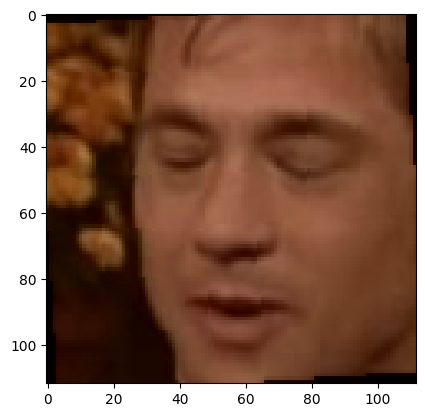

In [73]:
header_list = ["file","label"]
#read the metadata
labels = pd.read_csv('/content/drive/MyDrive/Gobal_metadata.csv',names=header_list)

#split the data into train and test
train_videos = video_files[:int(0.8*len(video_files))]
valid_videos = video_files[int(0.8*len(video_files)):]
print("train : " , len(train_videos))
print("test : " , len(valid_videos))

print("TRAIN: ", "Real:",number_of_real_and_fake_videos(train_videos)[0]," Fake:",number_of_real_and_fake_videos(train_videos)[1])
print("TEST: ", "Real:",number_of_real_and_fake_videos(valid_videos)[0]," Fake:",number_of_real_and_fake_videos(valid_videos)[1])


#Augment the data by applying transformations to train and test set
im_size = 112
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
train_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.RandomRotation(10),
                                        transforms.GaussianBlur(kernel_size=(5,5), sigma=(0.5, 0.5)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])

test_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])

#preprocess the data
train_data = video_dataset(train_videos,labels,sequence_length = 15,transform = train_transforms)
val_data = video_dataset(valid_videos,labels,sequence_length = 15,transform = test_transforms)

#load the data into dataloaders
train_loader = DataLoader(train_data,batch_size = 16,shuffle = True,num_workers = 4)
valid_loader = DataLoader(val_data,batch_size = 16,shuffle = True,num_workers = 4)

#plot the data
image,label = train_data[0]
im_plot(image[0,:,:,:])

## **Model 1 : Convolution Neural Network**

In [74]:
#Baseline CNN Model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3,32, kernel_size=(3, 3))
        self.conv2 = nn.Conv2d(32,32, kernel_size=(3, 3))
        self.max1 = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv3 = nn.Conv2d(32,64, kernel_size=(3, 3))
        self.conv4 = nn.Conv2d(64,64, kernel_size=(3, 3))
        self.max2 = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv5 = nn.Conv2d(64,128, kernel_size=(3, 3))
        self.conv6 = nn.Conv2d(128,128, kernel_size=(3, 3))
        self.max3 = nn.AvgPool2d(kernel_size=(2, 2))
        self.drop = nn.Dropout(p=0.3)

        # 4x dense layers to learn from features extracted from convolutions
        self.l1 = nn.Linear(12800,584)
        self.l2 = nn.Linear(584,128)
        self.l3 = nn.Linear(128,32)
        self.l4 = nn.Linear(32,2)

    def forward(self, x):

        batch_size,seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.max1(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.max2(x)
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.max3(x)
        x = x.view(x.shape[0],-1)
        x = F.leaky_relu(self.l1(x))
        x = F.leaky_relu(self.l2(x))
        x = self.drop(x)
        x = F.relu(self.l3(x))
        x = self.l4(x)
        output = F.softmax(x, dim=1)
        return output


In [75]:
#instantiate the model
model1 = CNNModel().cuda()

In [76]:
#train function for CNN Model
def train_epoch(epoch, num_epochs, data_loader, model, criterion, optimizer):
    model.train()
    losses = AverageMeter()
    accuracies = AverageMeter()
    t = []
    for i, (inputs, targets) in enumerate(data_loader):

        if torch.cuda.is_available():
            targets = targets.type(torch.cuda.LongTensor)
            inputs = inputs.cuda()

        bs,seq_length, c, h, w = inputs.shape
        outputs = model(inputs)   #call the model with inputs
        results = torch.zeros((bs,2)).cuda()
        c = 0

        #calculate the mean output for each frame in the input sequence.
        for j in range(0,bs,seq_length):
            results[c] = torch.mean(outputs[j:j+seq_length],dim=0)
            c = c+1

        #calculate loss and accuracy
        loss  = criterion(results,targets.type(torch.cuda.LongTensor))
        acc = calculate_accuracy(results, targets.type(torch.cuda.LongTensor))
        losses.update(loss.item(), inputs.size(0))
        accuracies.update(acc, inputs.size(0))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sys.stdout.write(
                "\r[Epoch %d/%d] [Batch %d / %d] [Loss: %f, Acc: %.2f%%]"
                % (
                    epoch,
                    num_epochs,
                    i,
                    len(data_loader),
                    losses.avg,
                    accuracies.avg))
    torch.save(model.state_dict(),'/content/CNN_Model.pt')
    return losses.avg,accuracies.avg

#test function
def test(epoch,model, data_loader ,criterion):
    print('Testing')
    model.eval()
    losses = AverageMeter()
    accuracies = AverageMeter()
    pred = []
    true = []
    count = 0
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(data_loader):
            if torch.cuda.is_available():
                targets = targets.cuda().type(torch.cuda.LongTensor)
                inputs = inputs.cuda()


            batch_size,seq_length, c, h, w = inputs.shape
            outputs = model(inputs)
            results = torch.zeros((batch_size,2)).cuda()
            c = 0
            for j in range(0,batch_size,seq_length):
                results[c] = torch.mean(outputs[j:j+seq_length],dim=0)
                c = c+1
            loss = torch.mean(criterion(results, targets.type(torch.cuda.LongTensor)))
            acc = calculate_accuracy(results,targets.type(torch.cuda.LongTensor))
            _,p = torch.max(results,1)
            true += (targets.type(torch.cuda.LongTensor)).detach().cpu().numpy().reshape(len(targets)).tolist()
            pred += p.detach().cpu().numpy().reshape(len(p)).tolist()
            losses.update(loss.item(), inputs.size(0))
            accuracies.update(acc, inputs.size(0))
            sys.stdout.write(
                    "\r[Batch %d / %d]  [Loss: %f, Acc: %.2f%%]"
                    % (
                        i,
                        len(data_loader),
                        losses.avg,
                        accuracies.avg
                        )
                    )
        print('\nAccuracy {}'.format(accuracies.avg))
    return true,pred,losses.avg,accuracies.avg

In [77]:
#learning rate
lr = 0.001

#number of epochs
num_epochs = 20

optimizer = torch.optim.Adam(model1.parameters(), lr= lr)

criterion = nn.CrossEntropyLoss().cuda()
train_loss_avg =[]
train_accuracy = []
test_loss_avg = []
test_accuracy = []
for epoch in range(1,num_epochs+1):
    l, acc = train_epoch(epoch,num_epochs,train_loader,model1,criterion,optimizer)
    train_loss_avg.append(l)
    train_accuracy.append(acc)
    true,pred,tl,t_acc = test(epoch,model1,valid_loader,criterion)
    test_loss_avg.append(tl)
    test_accuracy.append(t_acc)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[Epoch 1/20] [Batch 58 / 59] [Loss: 0.693500, Acc: 49.46%]Testing
[Batch 14 / 15]  [Loss: 0.690606, Acc: 49.57%]
Accuracy 49.572649572649574
[Epoch 2/20] [Batch 58 / 59] [Loss: 0.693411, Acc: 49.68%]Testing
[Batch 14 / 15]  [Loss: 0.692715, Acc: 49.57%]
Accuracy 49.572649572649574
[Epoch 3/20] [Batch 58 / 59] [Loss: 0.693767, Acc: 49.68%]Testing
[Batch 14 / 15]  [Loss: 0.692826, Acc: 49.57%]
Accuracy 49.572649572649574
[Epoch 4/20] [Batch 58 / 59] [Loss: 0.693500, Acc: 49.57%]Testing
[Batch 14 / 15]  [Loss: 0.693119, Acc: 50.85%]
Accuracy 50.85470085470085
[Epoch 5/20] [Batch 58 / 59] [Loss: 0.693280, Acc: 49.25%]Testing
[Batch 14 / 15]  [Loss: 0.692995, Acc: 49.57%]
Accuracy 49.572649572649574
[Epoch 6/20] [Batch 58 / 59] [Loss: 0.693212, Acc: 49.68%]Testing
[Batch 14 / 15]  [Loss: 0.693181, Acc: 49.57%]
Accuracy 49.572649572649574
[Epoch 7/20] [Batch 58 / 59] [Loss: 0.693139, Acc: 49.04%]Testing
[Batch 14 / 15]  [Loss: 0.693105, Acc: 49.57%]
Accuracy 49.572649572649574
[Epoch 8/20] [

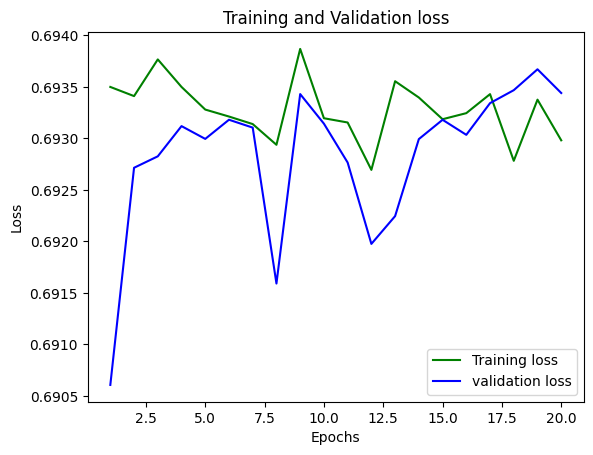

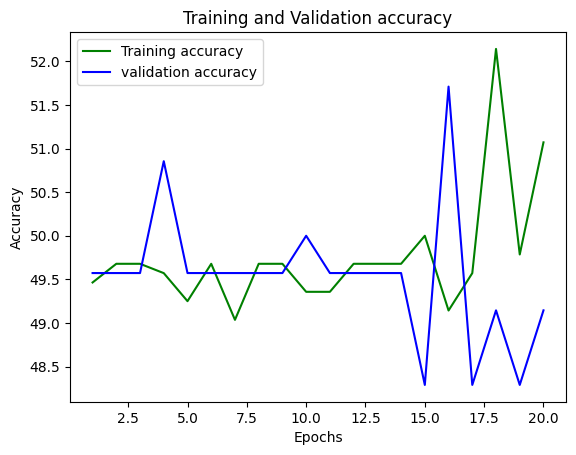

In [78]:
#plot of loss and accuracy for CNN
plot_loss(train_loss_avg,test_loss_avg,len(train_loss_avg))
plot_accuracy(train_accuracy,test_accuracy,len(train_accuracy))

[[101  15]
 [104  14]]
True positive =  101
False positive =  15
False negative =  104
True negative =  14




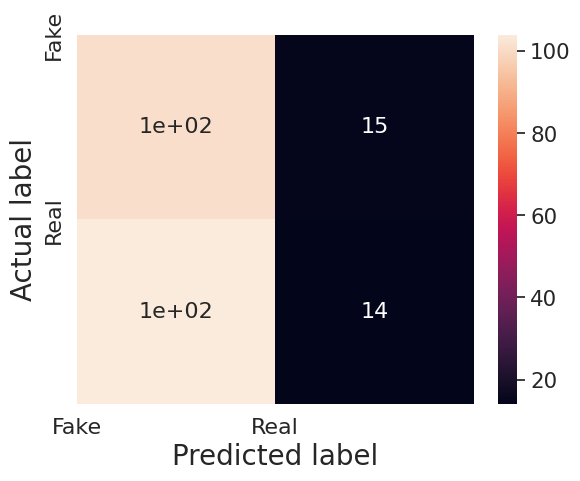

Calculated Accuracy 49.14529914529914


In [79]:
#confusion matrix for CNN
print(confusion_matrix(true,pred))
print_confusion_matrix(true,pred)

## **Model 2: ResNext + LSTM**

In [80]:
# Model with Pretrained ResNext with LSTM layers
class ResNext_LSTM_Model(nn.Module):
    def __init__(self, num_classes,latent_dim= 2048, lstm_layers=1 , hidden_dim = 2048, bidirectional = False):
        super(ResNext_LSTM_Model, self).__init__()
        model = models.resnext50_32x4d(pretrained = True) #Residual Network CNN pretrained model
        self.model = nn.Sequential(*list(model.children())[:-2])
        self.lstm = nn.LSTM(latent_dim,hidden_dim, lstm_layers,  bidirectional) #LSTM Layer
        self.relu = nn.LeakyReLU()
        self.dp = nn.Dropout(0.4)
        self.linear1 = nn.Linear(2048,512)
        self.linear2 = nn.Linear(512,num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        batch_size,seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)
        fmap = self.model(x)
        x = self.avgpool(self.relu(fmap))
        x = x.view(batch_size,seq_length,2048)
        x_lstm,_ = self.lstm(x,None)
        x = F.relu(self.linear1(torch.mean(x_lstm,dim = 1)))
        x = self.dp(x)
        x = self.linear2(x)
        return fmap, x #return the feature map from ResNext and model output

In [81]:
#instantiate the model
model2 = ResNext_LSTM_Model(2).cuda()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 158MB/s]


In [82]:
#Train funtion for ResNext_LSTM_Model
def train_epoch(epoch, num_epochs, data_loader, model, criterion, optimizer):
    model.train()
    losses = AverageMeter()
    accuracies = AverageMeter()
    t = []
    for i, (inputs, targets) in enumerate(data_loader):
        if torch.cuda.is_available():
            targets = targets.type(torch.cuda.LongTensor)
            inputs = inputs.cuda()
        _,outputs = model(inputs)
        loss  = criterion(outputs,targets.type(torch.cuda.LongTensor))
        acc = calculate_accuracy(outputs, targets.type(torch.cuda.LongTensor))
        losses.update(loss.item(), inputs.size(0))
        accuracies.update(acc, inputs.size(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sys.stdout.write(
                "\r[Epoch %d/%d] [Batch %d / %d] [Loss: %f, Acc: %.2f%%]"
                % (
                    epoch,
                    num_epochs,
                    i,
                    len(data_loader),
                    losses.avg,
                    accuracies.avg))
    torch.save(model.state_dict(),'/content/ResNext_LSTM_Model.pt') #save the model
    return losses.avg,accuracies.avg

#Test Function for ResNext_LSTM_Model
def test(epoch,model, data_loader ,criterion):
    print('Testing')
    model.eval()
    losses = AverageMeter()
    accuracies = AverageMeter()
    pred = []
    true = []
    count = 0
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(data_loader):
            if torch.cuda.is_available():
                targets = targets.cuda().type(torch.cuda.FloatTensor)
                inputs = inputs.cuda()
            _,outputs = model(inputs)
            loss = torch.mean(criterion(outputs, targets.type(torch.cuda.LongTensor)))
            acc = calculate_accuracy(outputs,targets.type(torch.cuda.LongTensor))
            _,p = torch.max(outputs,1)
            true += (targets.type(torch.cuda.LongTensor)).detach().cpu().numpy().reshape(len(targets)).tolist()
            pred += p.detach().cpu().numpy().reshape(len(p)).tolist()
            losses.update(loss.item(), inputs.size(0))
            accuracies.update(acc, inputs.size(0))
            sys.stdout.write(
                    "\r[Batch %d / %d]  [Loss: %f, Acc: %.2f%%]"
                    % (
                        i,
                        len(data_loader),
                        losses.avg,
                        accuracies.avg
                        )
                    )
        print('\nAccuracy {}'.format(accuracies.avg))
    return true,pred,losses.avg,accuracies.avg

In [83]:
#learning rate
lr = 1e-5 #0.001
#number of epochs
num_epochs = 10

optimizer = torch.optim.Adam(model2.parameters(), lr= lr,weight_decay = 0.001)
criterion = nn.CrossEntropyLoss().cuda()
train_loss_avg =[]
train_accuracy = []
test_loss_avg = []
test_accuracy = []

#call the train and test to fit the model
for epoch in range(1,num_epochs+1):
    l, acc = train_epoch(epoch,num_epochs,train_loader,model2,criterion,optimizer)
    train_loss_avg.append(l)
    train_accuracy.append(acc)
    true,pred,tl,t_acc = test(epoch,model2,valid_loader,criterion)
    test_loss_avg.append(tl)
    test_accuracy.append(t_acc)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[Epoch 1/10] [Batch 57 / 59] [Loss: 0.690401, Acc: 52.59%]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[Epoch 1/10] [Batch 58 / 59] [Loss: 0.690452, Acc: 52.46%]Testing
[Batch 14 / 15]  [Loss: 0.688112, Acc: 50.43%]
Accuracy 50.427350427350426
[Epoch 2/10] [Batch 58 / 59] [Loss: 0.672955, Acc: 61.24%]Testing
[Batch 14 / 15]  [Loss: 0.649952, Acc: 66.67%]
Accuracy 66.66666666666667
[Epoch 3/10] [Batch 58 / 59] [Loss: 0.552378, Acc: 76.02%]Testing
[Batch 14 / 15]  [Loss: 0.503560, Acc: 76.07%]
Accuracy 76.06837606837607
[Epoch 4/10] [Batch 58 / 59] [Loss: 0.306019, Acc: 89.40%]Testing
[Batch 14 / 15]  [Loss: 0.358042, Acc: 83.76%]
Accuracy 83.76068376068376
[Epoch 5/10] [Batch 58 / 59] [Loss: 0.181444, Acc: 93.58%]Testing
[Batch 14 / 15]  [Loss: 0.336179, Acc: 86.32%]
Accuracy 86.32478632478633
[Epoch 6/10] [Batch 58 / 59] [Loss: 0.091447, Acc: 97.64%]Testing
[Batch 14 / 15]  [Loss: 0.331982, Acc: 87.18%]
Accuracy 87.17948717948718
[Epoch 7/10] [Batch 58 / 59] [Loss: 0.059434, Acc: 98.50%]Testing
[Batch 14 / 15]  [Loss: 0.318897, Acc: 88.03%]
Accuracy 88.03418803418803
[Epoch 8/10] [Batch

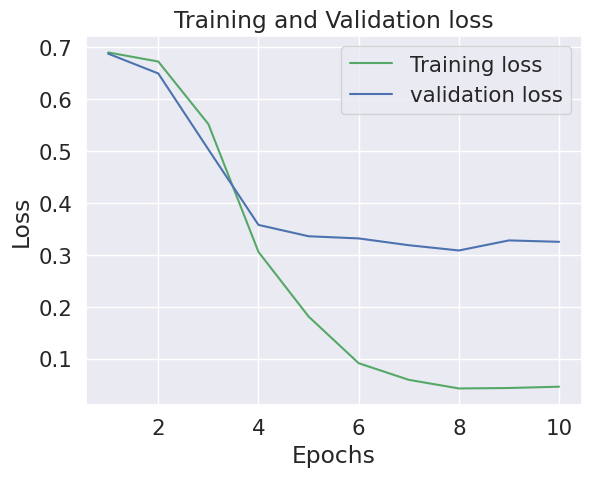

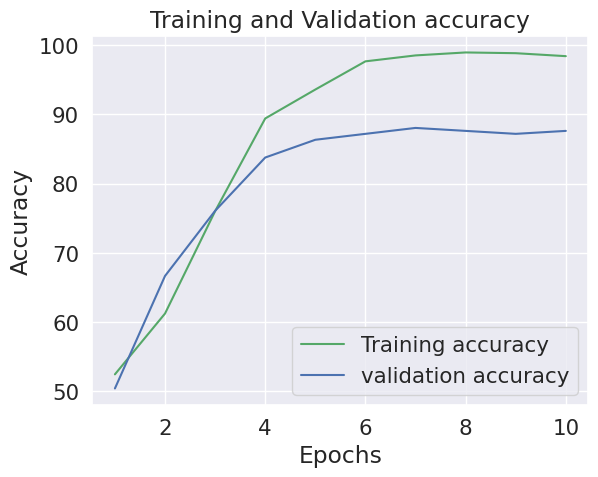

In [84]:
#plot of loss and accuracy for ResNext_LSTM_Model
plot_loss(train_loss_avg,test_loss_avg,len(train_loss_avg))
plot_accuracy(train_accuracy,test_accuracy,len(train_accuracy))

[[106  10]
 [ 19  99]]
True positive =  106
False positive =  10
False negative =  19
True negative =  99




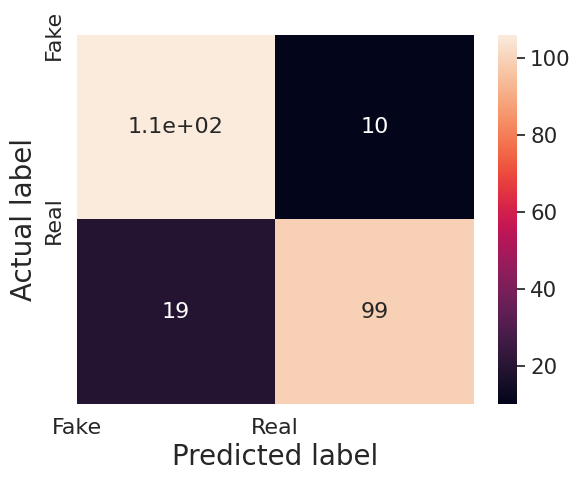

Calculated Accuracy 87.6068376068376


In [85]:
#Confusion Matrix ResNext_LSTM_Model
print(confusion_matrix(true,pred))
print_confusion_matrix(true,pred)

## **Model 3: EfficientNet + GRU**

In [86]:
#Model with Pretrained Efficient Net with GRU
class Efficient_GRU_Model(nn.Module):
    def __init__(self, num_classes,latent_dim= 1280, gru_layers=2 , hidden_dim = 1280, bidirectional = False):
        super(Efficient_GRU_Model, self).__init__()
        model = models.efficientnet_b0(pretrained = True) #Pretrained Efficient Net b0 Model
        self.model = nn.Sequential(*list(model.children())[:-2])
        self.gru = nn.GRU(latent_dim, hidden_dim, gru_layers, bidirectional) #GRU Layer
        self.relu = nn.LeakyReLU()
        self.dp = nn.Dropout(0.3)
        self.linear1 = nn.Linear(1280,256)
        self.linear2 = nn.Linear(256,128)
        self.linear3 = nn.Linear(128,num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        batch_size,seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)
        fmap = self.model(x)
        x = self.avgpool(fmap)
        x = x.view(batch_size,seq_length,1280)
        x_gru,_ = self.gru(x,None)
        x = self.relu((self.linear1(torch.mean(x_gru,dim = 1))))
        x = self.relu(self.dp(self.linear2(x)))
        x = self.linear3(x)
        return fmap,x

In [87]:
#instantiate the  Efficient_GRU_Model
model3 = Efficient_GRU_Model(2,bidirectional=True).cuda()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 135MB/s]


In [88]:
#train function for Efficient_GRU_Model
def train_epoch(epoch, num_epochs, data_loader, model, criterion, optimizer):
    model.train()
    losses = AverageMeter()
    accuracies = AverageMeter()
    t = []
    for i, (inputs, targets) in enumerate(data_loader):
        if torch.cuda.is_available():
            targets = targets.type(torch.cuda.LongTensor)
            inputs = inputs.cuda()
        _,outputs = model(inputs)
        loss  = criterion(outputs,targets.type(torch.cuda.LongTensor))
        acc = calculate_accuracy(outputs, targets.type(torch.cuda.LongTensor))
        losses.update(loss.item(), inputs.size(0))
        accuracies.update(acc, inputs.size(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sys.stdout.write(
                "\r[Epoch %d/%d] [Batch %d / %d] [Loss: %f, Acc: %.2f%%]"
                % (
                    epoch,
                    num_epochs,
                    i,
                    len(data_loader),
                    losses.avg,
                    accuracies.avg))
    torch.save(model.state_dict(),'EfficientNet_GRU_Model.pt')
    return losses.avg,accuracies.avg

#test function for Efficient_GRU_Model
def test(epoch,model, data_loader ,criterion):
    print('Testing')
    model.eval()
    losses = AverageMeter()
    accuracies = AverageMeter()
    pred = []
    true = []
    count = 0
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(data_loader):
            if torch.cuda.is_available():
                targets = targets.cuda().type(torch.cuda.FloatTensor)
                inputs = inputs.cuda()
            _,outputs = model(inputs)
            loss = torch.mean(criterion(outputs, targets.type(torch.cuda.LongTensor)))
            acc = calculate_accuracy(outputs,targets.type(torch.cuda.LongTensor))
            _,p = torch.max(outputs,1)
            true += (targets.type(torch.cuda.LongTensor)).detach().cpu().numpy().reshape(len(targets)).tolist()
            pred += p.detach().cpu().numpy().reshape(len(p)).tolist()
            losses.update(loss.item(), inputs.size(0))
            accuracies.update(acc, inputs.size(0))
            sys.stdout.write(
                    "\r[Batch %d / %d]  [Loss: %f, Acc: %.2f%%]"
                    % (
                        i,
                        len(data_loader),
                        losses.avg,
                        accuracies.avg
                        )
                    )
        print('\nAccuracy {}'.format(accuracies.avg))
    return true,pred,losses.avg,accuracies.avg

In [89]:
#learning rate
lr = 1e-5
#number of epochs
num_epochs = 20

optimizer = torch.optim.Adam(model3.parameters(), lr= lr,weight_decay = 1e-5)

criterion = nn.CrossEntropyLoss().cuda()
train_loss_avg =[]
train_accuracy = []
test_loss_avg = []
test_accuracy = []
for epoch in range(1,num_epochs+1):
    l, acc = train_epoch(epoch,num_epochs,train_loader,model3,criterion,optimizer)
    train_loss_avg.append(l)
    train_accuracy.append(acc)
    true,pred,tl,t_acc = test(epoch,model3,valid_loader,criterion)
    test_loss_avg.append(tl)
    test_accuracy.append(t_acc)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[Epoch 1/20] [Batch 58 / 59] [Loss: 0.693723, Acc: 49.68%]Testing
[Batch 14 / 15]  [Loss: 0.692571, Acc: 50.85%]
Accuracy 50.85470085470085
[Epoch 2/20] [Batch 58 / 59] [Loss: 0.693049, Acc: 50.32%]Testing
[Batch 14 / 15]  [Loss: 0.692304, Acc: 52.99%]
Accuracy 52.99145299145299
[Epoch 3/20] [Batch 58 / 59] [Loss: 0.692498, Acc: 54.50%]Testing
[Batch 14 / 15]  [Loss: 0.691755, Acc: 50.85%]
Accuracy 50.85470085470085
[Epoch 4/20] [Batch 58 / 59] [Loss: 0.690790, Acc: 57.17%]Testing
[Batch 14 / 15]  [Loss: 0.689264, Acc: 60.26%]
Accuracy 60.256410256410255
[Epoch 5/20] [Batch 58 / 59] [Loss: 0.686619, Acc: 58.24%]Testing
[Batch 14 / 15]  [Loss: 0.682798, Acc: 62.82%]
Accuracy 62.82051282051282
[Epoch 6/20] [Batch 58 / 59] [Loss: 0.672782, Acc: 67.24%]Testing
[Batch 14 / 15]  [Loss: 0.648538, Acc: 68.80%]
Accuracy 68.80341880341881
[Epoch 7/20] [Batch 58 / 59] [Loss: 0.608070, Acc: 71.95%]Testing
[Batch 14 / 15]  [Loss: 0.526072, Acc: 77.35%]
Accuracy 77.35042735042735
[Epoch 8/20] [Batch

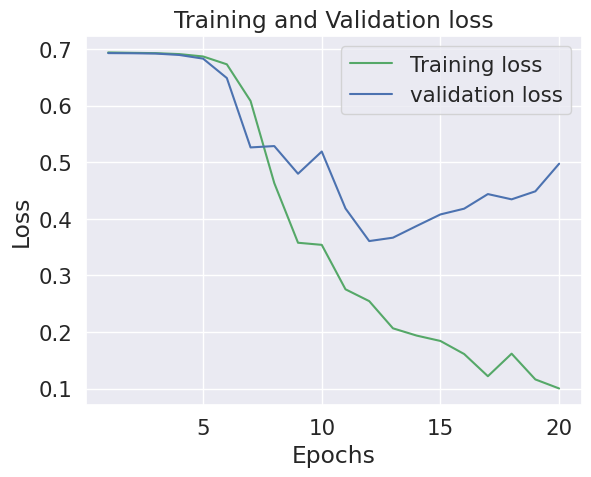

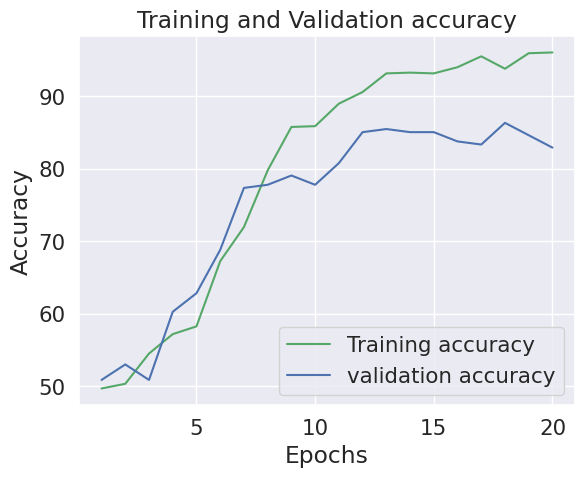

In [90]:
#plot of loss and accuracy for Efficient_GRU_Model
plot_loss(train_loss_avg,test_loss_avg,len(train_loss_avg))
plot_accuracy(train_accuracy,test_accuracy,len(train_accuracy))

[[108   8]
 [ 32  86]]
True positive =  108
False positive =  8
False negative =  32
True negative =  86




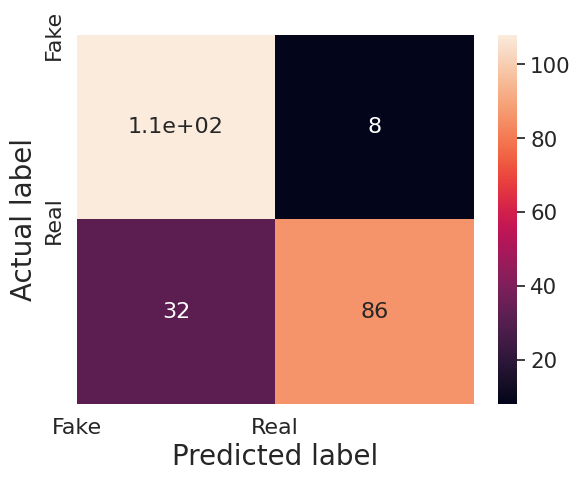

Calculated Accuracy 82.90598290598291


In [91]:
#Confusion Matrix for Efficient_GRU_Model
print(confusion_matrix(true,pred))
print_confusion_matrix(true,pred)